In [1]:
%matplotlib inline

In [2]:
import os
import sys
import netCDF4
import numpy as np
from geophys_utils import NetCDFPointUtils, get_spatial_ref_from_wkt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from math import log10, ceil, floor, pow
from pprint import pprint
#print(sys.version)
#pprint(dict(os.environ))

In [3]:
def rescale_array(input_np_array, new_range_min=0, new_range_max=1):
    old_min = input_np_array.min()
    old_range = input_np_array.max() - old_min
    new_range = new_range_max - new_range_min

    scaled_np_array = ((input_np_array - old_min) / old_range * new_range) + new_range_min

    return scaled_np_array

In [4]:
def plot_survey_points(netcdf_point_utils, # NetCDFPointUtils object wrapping a netCDF dataset
                       variable_to_map, # String specifying variable name for colour map
                       utm_bbox=None, # utm_bbox is of form [xmin, ymin, xmax, ymax]
                       colour_scheme='binary', # Colour map
                       point_size=10 # Size of point in plot
                       ):

        utm_wkt, utm_coords = netcdf_point_utils.utm_coords(netcdf_point_utils.xycoords[:])

        utm_zone = get_spatial_ref_from_wkt(utm_wkt).GetUTMZone() # -ve for Southern Hemisphere
        southern_hemisphere = (utm_zone < 0)
        utm_zone = abs(utm_zone)
        projection = ccrs.UTM(zone=utm_zone, southern_hemisphere=southern_hemisphere)
        print('utm_zone = {}'.format(utm_zone))
        #print(utm_coords)

        variable = netcdf_point_utils.netcdf_dataset.variables[variable_to_map]

        # Set geographic range of plot
        if utm_bbox is None:
            utm_bbox = [
                np.min(utm_coords[:,0]),
                np.min(utm_coords[:,1]),
                np.max(utm_coords[:,0]),
                np.max(utm_coords[:,1])
                ]
            spatial_mask = np.ones(shape=variable.shape, dtype='Bool')
        else:
            spatial_mask = np.logical_and(np.logical_and((utm_bbox[0] <= utm_coords[:,0]), 
                                                         (utm_coords[:,0] <= utm_bbox[2])), 
                                          np.logical_and((utm_bbox[1] <= utm_coords[:,1]), 
                                                         (utm_coords[:,1] <= utm_bbox[3]))
                                          )
            utm_coords = utm_coords[spatial_mask]
        
        print('UTM bounding box: {}'.format(utm_bbox))
        #print(utm_coords)
        
        colour_array = rescale_array(variable[spatial_mask], 0, 1)

        #map_image = cimgt.OSM() # https://www.openstreetmap.org/about
        #map_image = cimgt.StamenTerrain() # http://maps.stamen.com/
        map_image = cimgt.QuadtreeTiles()
        fig = plt.figure(figsize=(30,30))

        ax = fig.add_subplot(1, 1, 1, projection=projection)

        ax.set_title("Point Gravity Survey - " + str(netcdf_point_utils.netcdf_dataset.getncattr('title')))

        ax.add_image(map_image, 10)

        # Compute and set regular tick spacing
        range_x = utm_bbox[2] - utm_bbox[0]
        range_y = utm_bbox[3] - utm_bbox[1]       
        x_increment = pow(10.0, floor(log10(range_x))) / 2
        y_increment = pow(10.0, floor(log10(range_y))) / 2        
        x_ticks = np.arange((utm_bbox[0]//x_increment+1)*x_increment, utm_bbox[2], x_increment)
        y_ticks = np.arange((utm_bbox[1]//y_increment+1)*y_increment, utm_bbox[3], y_increment)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)

        # set the x and y axis labels
        ax.set_xlabel("Eastings (m)", rotation=0, labelpad=20)
        ax.set_ylabel("Northings (m)", rotation=90, labelpad=20)

        # See link for possible colourmap schemes: https://matplotlib.org/examples/color/colormaps_reference.html
        cm = plt.cm.get_cmap(colour_scheme)

        # build a scatter plot of the specified data, define marker, spatial reference system, and the chosen colour map type
        sc = ax.scatter(utm_coords[:,0], 
                        utm_coords[:,1], 
                        marker='o', 
                        c=colour_array, 
                        s=point_size, 
                        alpha=0.9, 
                        transform=projection, 
                        cmap=cm
                       )

        # set the colour bar ticks and labels
        cb = plt.colorbar(sc, ticks=[0, 1])
        cb.ax.set_yticklabels([str(np.min(variable)), str(np.max(variable))])  # vertically oriented colorbar
        cb.set_label("{} {}".format(variable.long_name, variable.units))

        plt.show()

In [5]:
# Create NetCDFPointUtils object for specified netCDF dataset
netcdf_path = 'http://dapds00.nci.org.au/thredds/dodsC/uc0/rr2_dev/axi547/ground_gravity/point_datasets/201780.nc'
#netcdf_path = 'E:\\Temp\\gravity_point_test\\201780.nc'

netcdf_dataset = netCDF4.Dataset(netcdf_path)
npu = NetCDFPointUtils(netcdf_dataset)

utm_zone = 53
UTM bounding box: [539789.6868594976, 7983841.687825138, 728564.7401507163, 8304015.832502202]


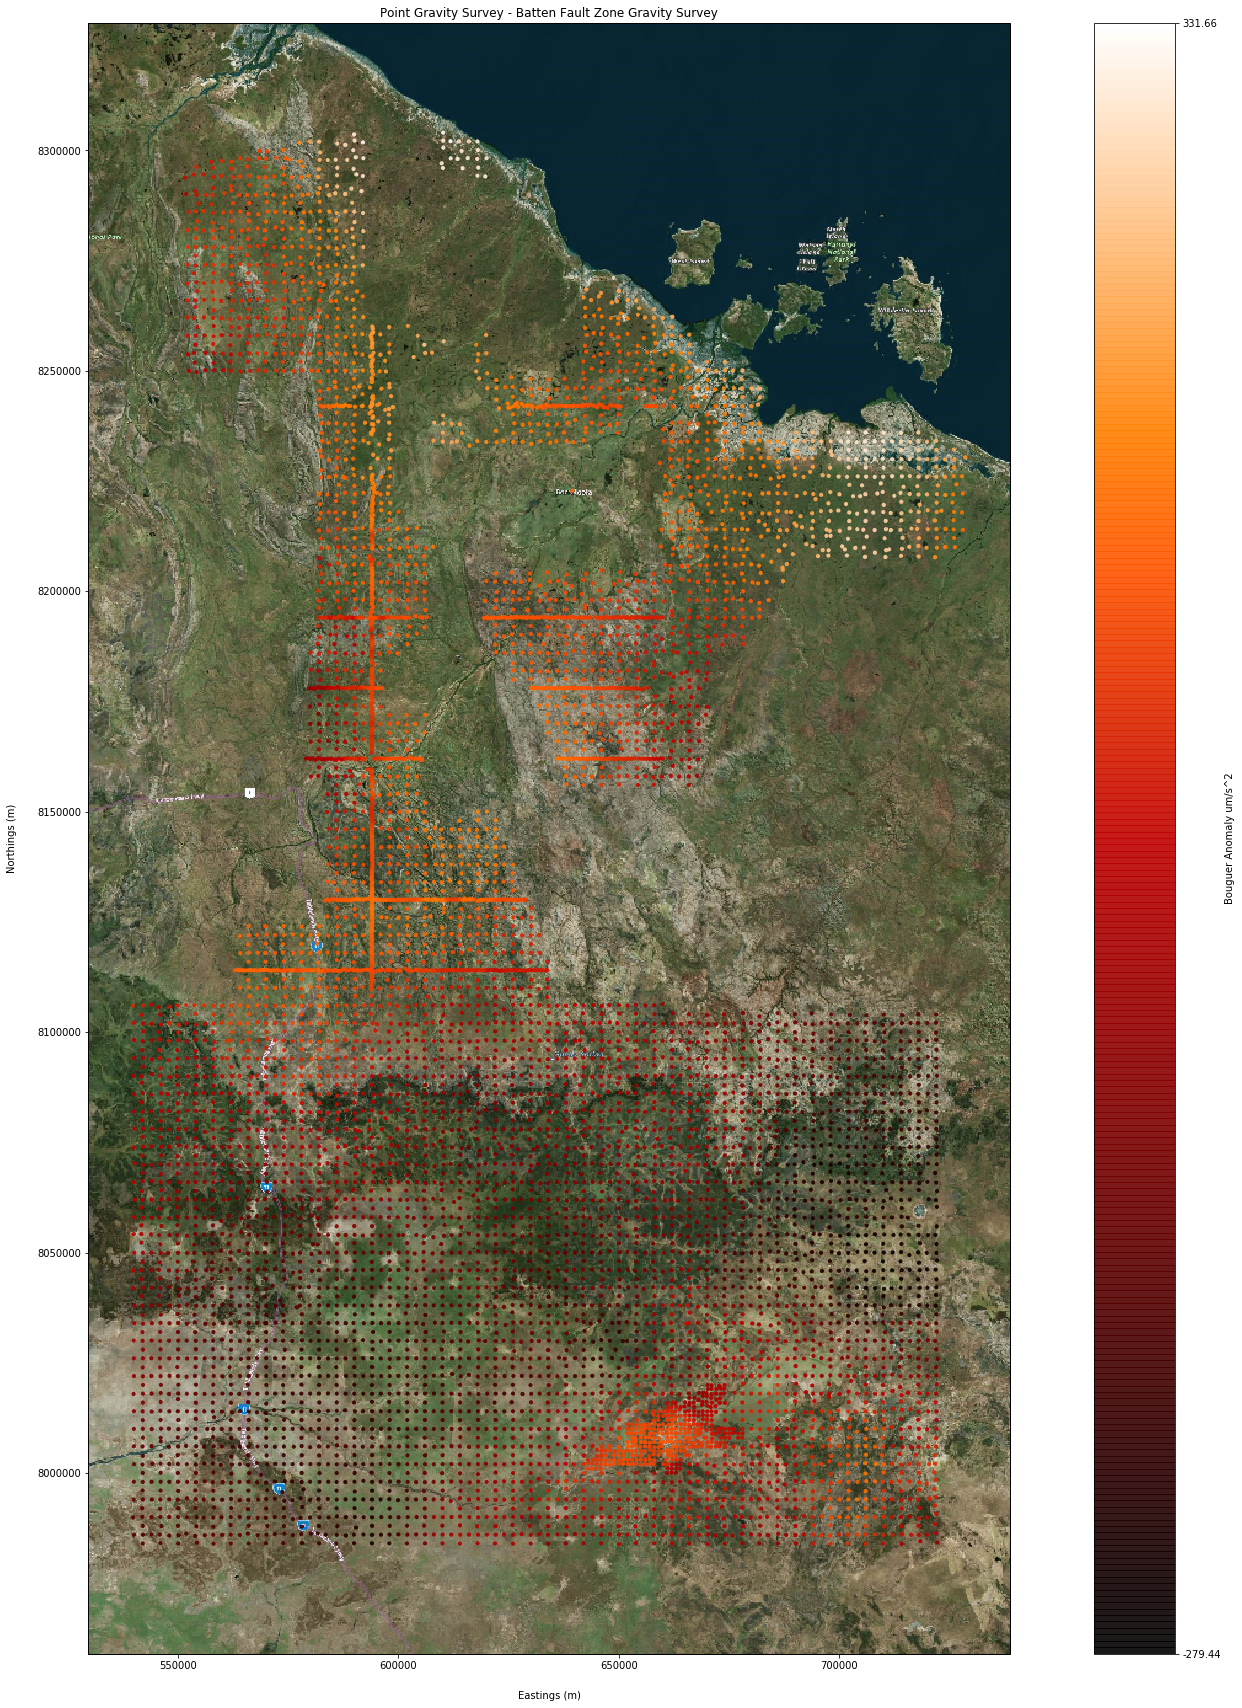

In [6]:
# Plot entire survey
plot_survey_points(npu, 
                   'Bouguer', 
                   colour_scheme='gist_heat')

utm_zone = 53
UTM bounding box: [630000, 7980000, 680000, 8030000]


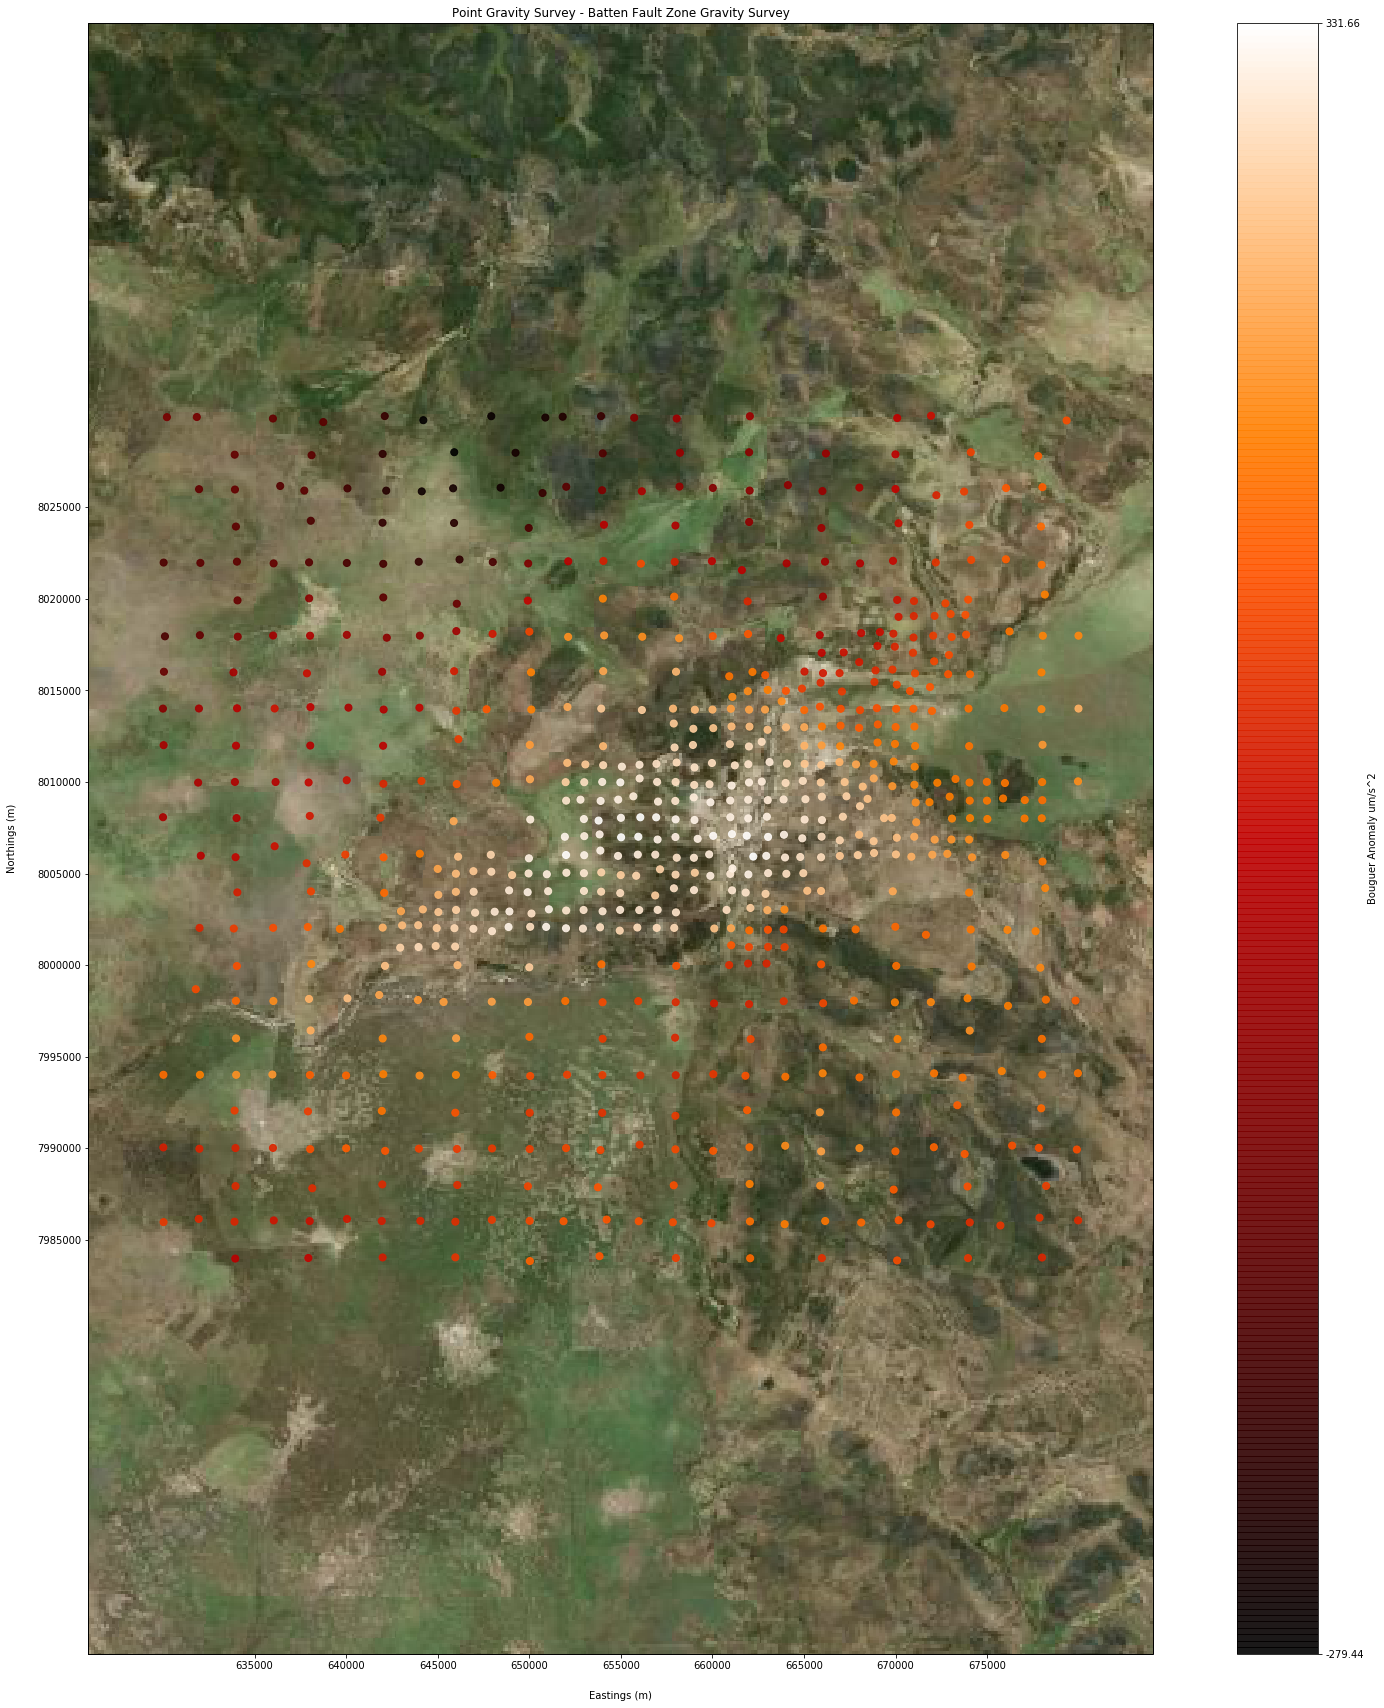

In [7]:
# Plot spatial subset
plot_survey_points(npu, 
                   'Bouguer', 
                   utm_bbox=[630000,7980000,680000,8030000],
                   colour_scheme='gist_heat',
                   point_size=50)

utm_zone = 53
UTM bounding box: [660000, 8000000, 665000, 8005000]


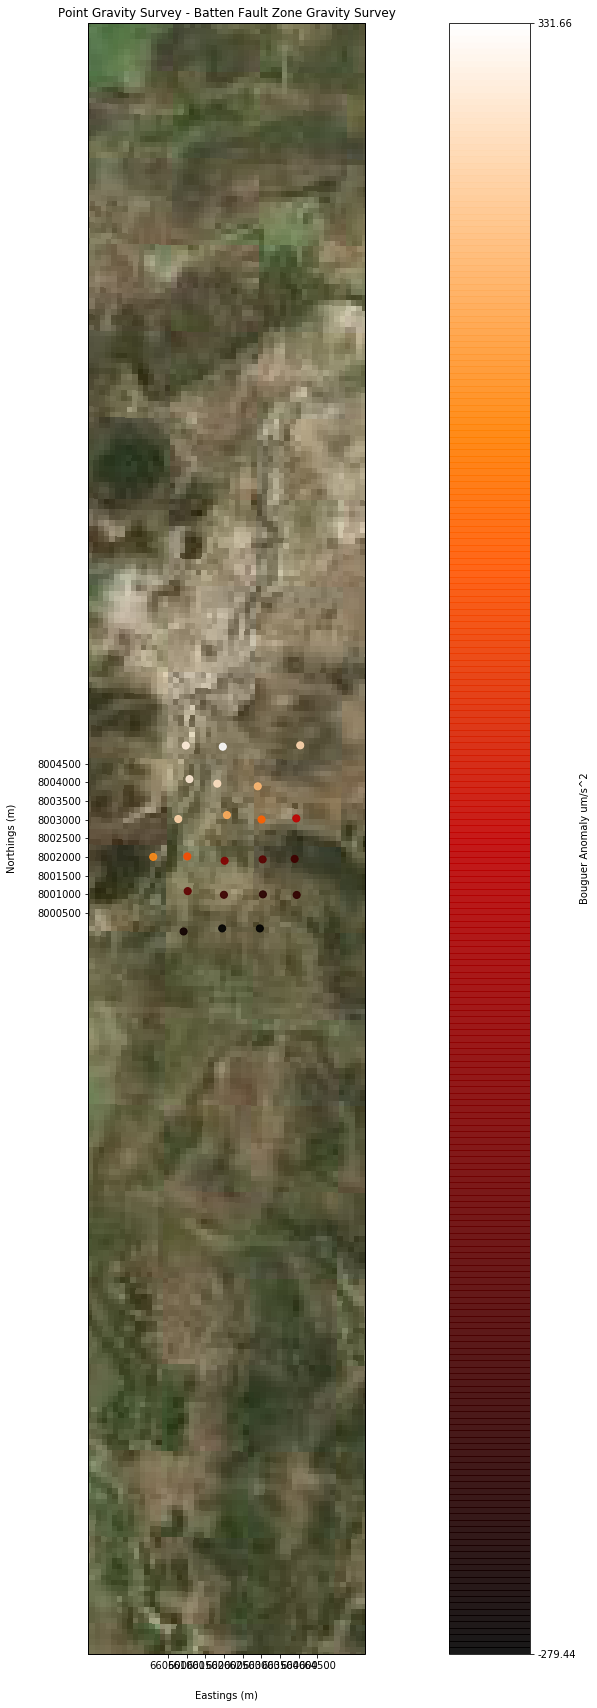

In [8]:
# Plot even smaller spatial subset
plot_survey_points(npu, 
                   'Bouguer', 
                   utm_bbox=[660000,8000000,665000,8005000],
                   colour_scheme='gist_heat',
                   point_size=50)